# CVAE Training and RSA Results

### Imports

In [1]:
import os 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import matplotlib as mpl
from IPython import display
import time
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from matplotlib import colors
from sklearn.decomposition import PCA

from make_models import get_MRI_VAE_3D,get_MRI_CVAE_3D
from rsa_funcs import fit_rsa,make_RDM,get_triu

### Load and Sort Data

In [2]:
data_arr = np.load('../../BC-sim/BC-sim-bigdata/synth-data-01/sim-brain-array-1.npz')
print(list(data_arr.keys()))
data = data_arr['data']
control = data_arr['controls']
patients = data_arr['patients']
n = data.shape[0]
print(data.shape)
data[patients,:,:,:].shape
data[patients].shape
data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

['data', 'controls', 'patients']
(1000, 64, 64, 64)


In [3]:
print(control)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

### Create Data Loader

In [4]:
class cvae_data_loader_adhd():
    ''' this is the info'''
    def __init__(self,data,patients,batch_size=32):
    
        self.data = data
        
        self.n = data.shape[0]
        self.epoch = -1
        self.batch_size = batch_size
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.adhd_idxs),len(self.td_idxs)))/self.batch_size)) # How many batches fit, take the min(n_ADHD,n_TD) then divide by batch size
        
    def new_epoch(self):

        self.adhd_idxs = np.nonzero(patients==True)[0] # idxs of patients
        self.td_idxs = np.nonzero(patients==False)[0] # idxs of TDs
        
        self.adhd_idxs = np.random.permutation(self.adhd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_adhd_idx = self.adhd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        # go through the patients and controls in batch size chunks
        # batch_indeces = all_indices[batch number * batch size : batch number * batch size + batch size]
        
        self.batch_adhd = self.data[self.batch_adhd_idx,:,:,:]
        self.batch_td = self.data[self.batch_td_idx,:,:,:]
        
        _,counts = np.unique(np.hstack((self.batch_adhd_idx,self.batch_td_idx)),return_counts=True)
        assert all(counts==1),'not all unique, somethings wrong'
        
        return self.batch_adhd,self.batch_td

### Apply the Above Data Loader to Dataset

In [5]:
data_loader = cvae_data_loader_adhd(data,patients)

### Tensorflow / GPU Check

In [6]:
tf.__version__

'2.3.1'

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

### CVAE

In [6]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1, # controls how far away latent features can go from normal distribution, stronger beta = more nromally distributed features
                    disentangle=False, # activates the decorrelation from gamma, next time True 
                    gamma=1, # total correlation loss that penalizes for z and s features being correlated, can be increased to 100
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

### CVAE: 100 epochs

#### Training

In [8]:
# Make sure you have GPU enabled
# Test 100 epochs
# n_epochs = 100
# n_batches = data_loader.n_batches # dataloader calcs how many batches
# loss = []
# for epoch in tqdm(range(n_epochs)):
#     for batch in range(n_batches):
#         if np.mod(epoch, 10) == 0:
#             cvae.save_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_100_epochs') 
#         adhd_batch, td_batch = data_loader.get_batch()
#         l = cvae.train_on_batch([adhd_batch,td_batch]) # [TG,BG]
#         loss.append(l)
#         if np.mod(epoch, 10) == 0:
#             np.save('sim_loss_100_epochs', np.array(loss))

#### Load Weights

In [9]:
# cvae.load_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_100_epochs')

ValueError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_100_epochs: Not found: /mmfs1/data/bergerar/BC-sim/synth-data-01; No such file or directory

#### Get Reconstructions

In [7]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [8]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 2min 41s, sys: 17.2 s, total: 2min 58s
Wall time: 3min 5s


In [9]:
recon_patients.shape

TensorShape([500, 64, 64, 64])

In [10]:
np.array(recon_patients).max()

0.50001425

In [11]:
np.array(recon_patients).min()

0.49997902

In [12]:
np.array(data_patients).max()


0.99995524

In [13]:
np.array(data_patients).min()


0.0

#### Reconstruction: Subject 0

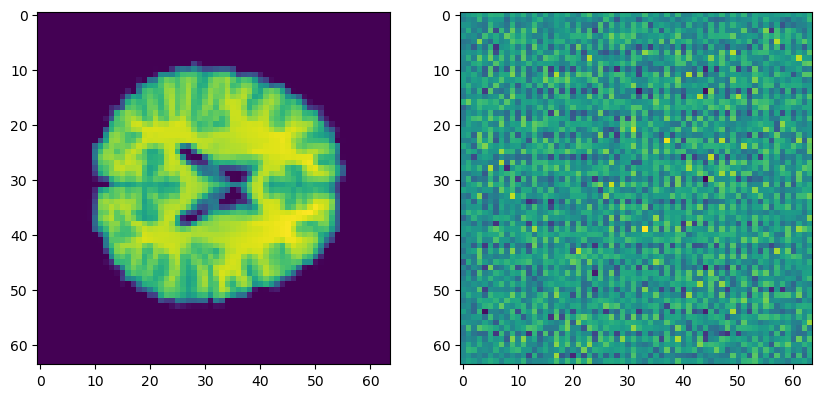

In [14]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

### CVAE: 10,000 Epochs

#### Training

In [10]:
# Make sure you have GPU enabled
# 5000 epochs

# n_epochs = 5000
# n_batches = data_loader.n_batches # dataloader calcs how many batches
# loss = []
# for epoch in tqdm(range(n_epochs)):
#     for batch in range(n_batches):
#         if np.mod(epoch, 10) == 0:
#              cvae.save_weights('/mmfs1/data/bergerar/BC-sim/BC-sim-bigdata/synth-data-01/sim_weights_5k_epochs') 
#         adhd_batch, td_batch = data_loader.get_batch()
#         l = cvae.train_on_batch([adhd_batch,td_batch]) # [TG,BG]
#         loss.append(l)
#         if np.mod(epoch, 10) == 0:
#             np.save('sim_loss_5k_epochs', np.array(loss))

100%|██████████| 5000/5000 [12:44:21<00:00,  9.17s/it]  


In [ ]:
# if train_cvae:
    
#    cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
#                    latent_dim=2,
#                    beta=1,
#                    disentangle=False,
#                    gamma=1,
#                    bias=True,
#                    batch_size = 64,
#                    kernel_size = 3,
#                    filters = 32,
#                    intermediate_dim = 128,
#                    opt=None)
#    loss = []

In [ ]:
#TD_subs = data[controls,:,:,:] # Data of Typically Developing participants 
#DX_subs = data[patients,:,:,:] # Data of ADHD participants


#nbatches = 50
#if train_cvae:
#    for i in tqdm(range(1,nbatches)):
#        
#        DX_batch = DX_subs[np.random.randint(low=0,high=DX_subs.shape[0],size=batch_size),:,:,:];
#        TD_batch = TD_subs[np.random.randint(low=0,high=TD_subs.shape[0],size=batch_size),:,:,:];
        
#        hist = cvae.train_on_batch([DX_batch,TD_batch]);
#        loss.append(hist);
        
#        mse = ((np.array([DX_batch,TD_batch])-np.array(cvae.predict([DX_batch,TD_batch]))[:,:,:,:,:,0])**2).mean()

#        assert not np.isnan(hist),'loss is NaN - somethings wrong'

#        im,im1,ss = cvae_query(data, s_encoder, z_encoder, cvae_decoder); 


#        if np.mod(i,5)==0: # Plot training progress
#            plot_trainProgress(loss,im,im1);
#            pickle.dump(loss,open(fn+'_loss.pickle','wb'))
#            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=0)
#            plot_four(DX_batch, TD_batch, z_encoder, s_encoder,cvae_decoder,cvae,idx=1)

#        if np.mod(i,101)==0: # Save every 100 batches
#            cvae.save_weights('/mmfs1/data/bergerar/BC-sim/synth-data-01/sim_weights_5k_epochs')
            
#        if mse < .005:
#            break

#### Load Weights

In [15]:
cvae.load_weights('/mmfs1/data/bergerar/BC-sim/BC-sim-bigdata/synth-data-01/sim_weights_5k_epochs')

#### Get Reconstructions

In [16]:
def get_reconstruction(data_in,adhd = True):

    z = z_encoder.predict(data_in)[0] # mu,std,sample
    s = s_encoder.predict(data_in)[0]

    if adhd==True:
        l = np.hstack((z,s))
    else:
        l = np.hstack((z,np.zeros(s.shape)))

    recon = cvae_decoder(l)[:,:,:,:,0]
    return recon

In [17]:
%%time
recon_patients = get_reconstruction(data_patients,adhd = True)
recon_controls = get_reconstruction(data_controls,adhd = False)


CPU times: user 2min 41s, sys: 17 s, total: 2min 58s
Wall time: 2min 59s


In [18]:
recon_patients.shape

TensorShape([500, 64, 64, 64])

In [19]:
np.array(recon_patients).max()

0.99738085

In [20]:
np.array(recon_patients).min()

0.0

In [21]:
np.array(data_patients).max()


0.99995524

In [22]:
np.array(data_patients).min()


0.0

#### Reconstruction: Subject 0

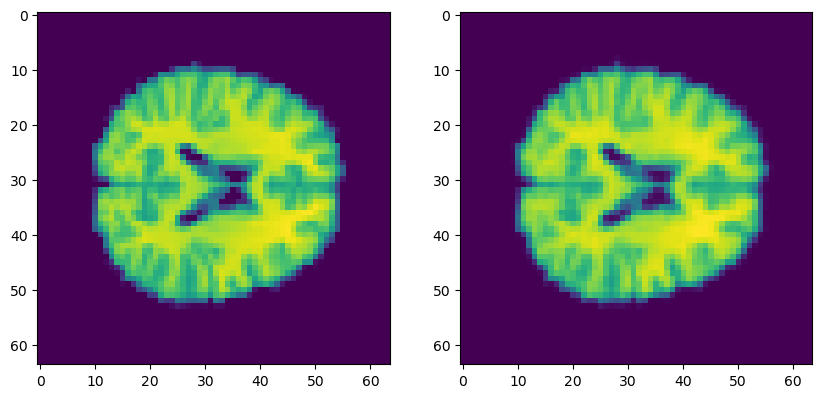

In [23]:
s = 0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

In [24]:
data = data_patients[0,:,:,:]
predict = recon_patients[0,:,:,:]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(data, predict).numpy()

0.00012293067

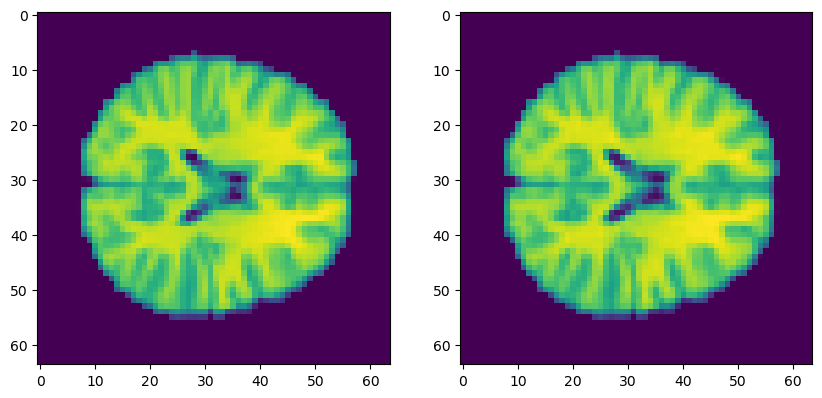

In [20]:
s = 1
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

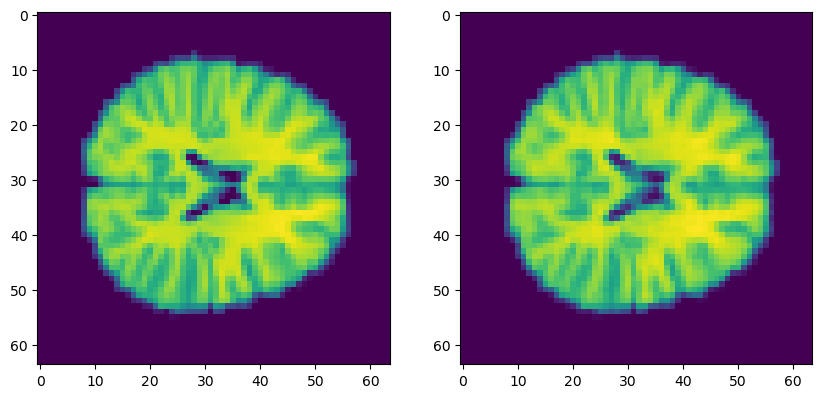

In [21]:
s = 100
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.show()

# Results

## Mean Squared Error

In [25]:
mse_list = []
for s in range(0,500):
    datas = np.array(data_patients[s,:,:,:])
    predict = np.array(recon_patients[s,:,:,:])
    mse = ((datas-predict)**2).mean()
    mse_list.append(mse)

mse_arr = np.array(mse_list)

# then subtract mean from original
# reshape from 500,64,64,64 to 1,64,64,64 dont just squish all of it down to one dimension

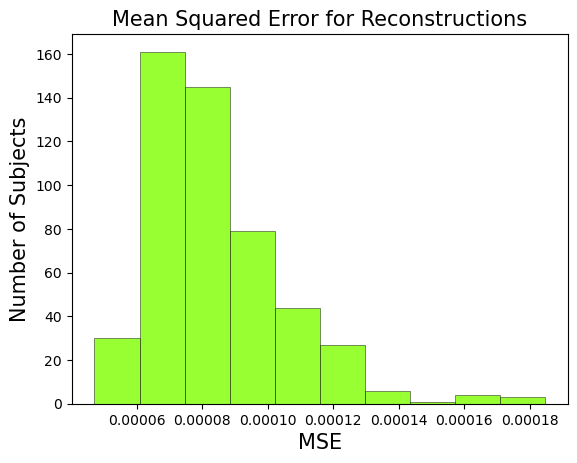

In [26]:
plt.hist(mse_arr, alpha = 0.8, color='chartreuse', edgecolor = 'black', linewidth=0.4 )
plt.title('Mean Squared Error for Reconstructions', fontsize = 15)
plt.xlabel('MSE', fontsize = 15)
plt.ylabel('Number of Subjects', fontsize = 15)
plt.show()

In [27]:
np.argmin(mse_arr) #

435

### Reconstruction with Lowest MSE (Best)

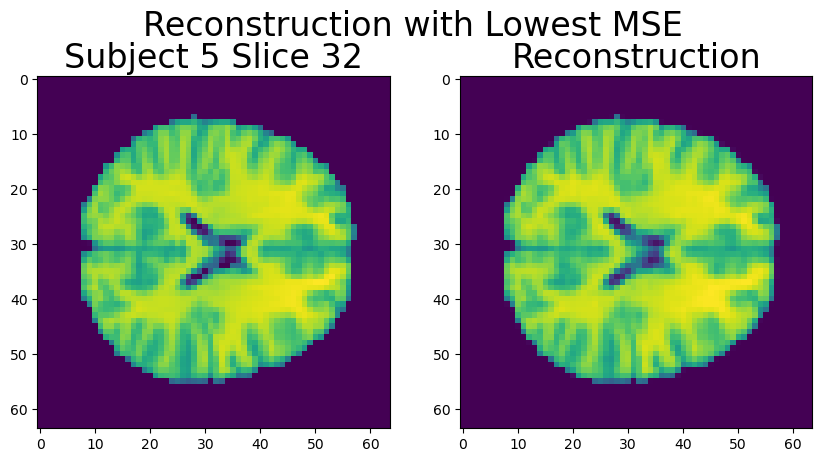

In [28]:
s = 435
figure = plt.figure(figsize=(10,5))
figure.suptitle('Reconstruction with Lowest MSE', fontsize=24)
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.title('Subject 5 Slice 32', fontsize = 24)
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.title('Reconstruction', fontsize = 24)
plt.show()

In [29]:
np.argmax(mse_arr) #

152

### Reconstruction with Highest MSE

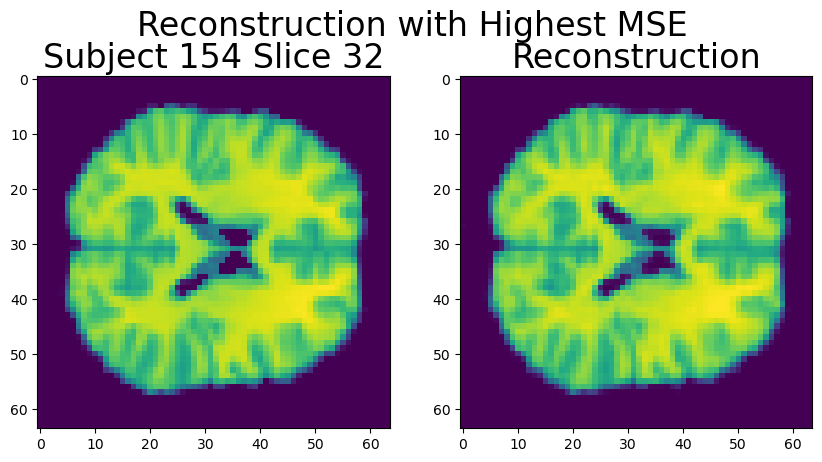

In [30]:
s = 356
figure2 = plt.figure(figsize=(10,5))
figure2.suptitle('Reconstruction with Highest MSE', fontsize=24)
plt.subplot(1,2,1)
plt.imshow(data_patients[s,:,:,32])
plt.title('Subject 154 Slice 32', fontsize = 24)
plt.subplot(1,2,2)
plt.imshow(recon_patients[s,:,:,32])
plt.title('Reconstruction', fontsize = 24)
plt.show()

## Diagnosis and Deformation Sizes

In [31]:
df = pd.read_csv('../../BC-sim/BC-sim-bigdata/synth-data-01/sim_all_def.csv')

In [32]:
ADHDdf = df[df['DX'] != 0]
TDdf = df[df['DX'] == 0]

In [33]:
ADHDdf

,Unnamed: 0,Index,Sub,Sphere 1,Sphere 2,DX,S Deformation,Z Deformation
0,0,0,0,12.834489,10.035014,1,-2.799475,-4.043705
1,1,1,1,11.011581,11.316208,1,0.304627,-3.733940
2,2,2,2,12.606499,14.643771,1,2.037272,-4.385604
3,3,3,3,10.869074,13.482636,1,2.613562,-4.925275
4,4,4,4,6.159082,6.337349,1,0.178267,1.429249
...,...,...,...,...,...,...,...,...
495,495,495,495,7.543617,9.531810,1,1.988193,1.969164
496,496,496,496,12.901628,10.921605,1,-1.980023,-1.618177
497,497,497,497,5.062251,3.099718,1,-1.962533,-4.174104
498,498,498,498,14.173622,13.385439,1,-0.788183,4.945449


## RSA

In [34]:
symptom_vector = ADHDdf['S Deformation'].values
symptom_vector

array([-2.79947527,  0.30462664,  2.03727205,  2.61356233,  0.17826748,
        0.53419311, -1.84472201,  1.88587619, -1.83464177,  1.35466179,
        1.41844268,  1.1432855 ,  0.51621531,  1.86163145, -0.49363845,
       -1.16619127, -2.94770216,  0.31849785, -0.39681439,  1.93356615,
        2.19137355,  2.47357005,  0.29687882,  1.27066434,  2.2811094 ,
       -1.81082647,  1.85152599, -1.80656489,  1.80041686, -1.144914  ,
        0.69133178, -0.95208009,  0.62800258, -0.6267277 , -1.15082105,
       -2.93080445, -1.34884795, -2.4554004 , -0.63545854,  0.17931633,
       -1.74709229,  0.83689515,  1.61844281, -1.04462509, -1.64994255,
       -1.3633386 , -2.24991411, -0.51175007,  1.30366083, -0.96027256,
        1.03042294, -1.04385548, -1.7209793 , -0.56308292,  2.2846093 ,
        1.49202453,  0.63547176, -0.60979895, -2.63442756, -1.29527528,
        2.86975519, -0.57091531, -1.81801214,  1.51082597,  1.56599708,
        2.76505613,  2.01808388,  2.44681336, -0.26802092, -0.81

In [35]:
background_vector = TDdf['Z Deformation'].values
background_vector

array([-4.04370491, -3.73393984, -4.38560359, -4.92527523,  1.42924905,
        4.30079046,  1.52833043, -1.20376912, -1.48021589,  3.66802482,
        1.67595101,  1.7080536 ,  3.01332007, -0.75389634,  3.23490449,
        2.53740186, -3.80199293,  3.44678755,  0.75226812, -3.20970884,
        1.06338283,  1.99836141, -0.71833463, -3.07848836, -4.26125679,
        1.05738852, -0.08606152,  3.41270866,  3.68033229,  2.01875627,
       -2.97384691,  3.50763305, -4.79792747,  4.59068652,  3.49982417,
        4.15274   ,  2.74885436, -1.36128744,  3.13379344, -1.3442818 ,
        4.27292509,  4.85317037, -1.80420255, -3.05723312,  0.11966433,
       -1.7449092 , -2.79001141, -4.60025238, -2.45808939,  3.48966798,
       -2.05021488,  4.84468482,  4.87865736, -3.22108005,  0.4431636 ,
        0.36387924,  1.9438954 , -2.54386161,  1.42293397,  2.65276553,
       -1.8399532 , -2.57725644, -2.22862402, -0.55212659,  1.38246452,
        2.66920504,  2.64866073, -0.90648468, -2.10014238,  0.32

In [36]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_vector)
background = np.array(background_vector)

In [37]:
s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)
symptom_rdm = make_RDM(symptom)
background_rdm = make_RDM(background)

In [38]:
symptom_rdm.shape

(500, 500)

In [39]:
z_patients_rdm.shape

(500, 500)

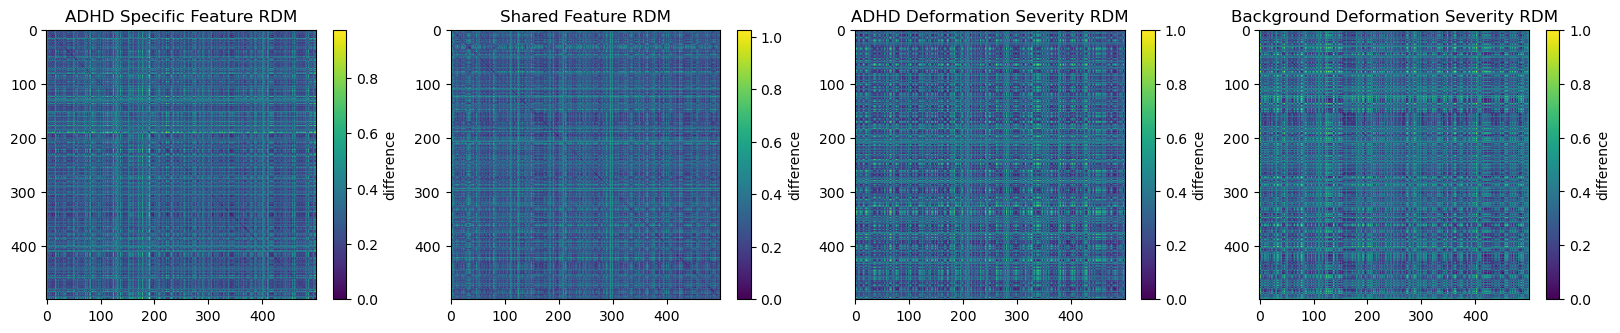

In [40]:
plt.figure(figsize = (20,5))
plt.subplot(1,4,1)
plt.imshow(s_patients_rdm)
plt.title('ADHD Specific Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,4,2)
plt.imshow(z_patients_rdm)
plt.title('Shared Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,4,3)
plt.imshow(symptom_rdm)
plt.title('ADHD Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,4,4)
plt.imshow(background_rdm)
plt.title('Background Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.show()

#### RSA: S Deformation

In [41]:
s_symptom_rsa = fit_rsa(s_patients_rdm, symptom_rdm)
s_symptom_rsa #should be higher

0.020931852834503602

In [42]:
z_symptom_rsa = fit_rsa(z_patients_rdm, symptom_rdm)
z_symptom_rsa

0.0035901091424471333

#### RSA: Z Deformation

In [43]:
s_background_rsa = fit_rsa(s_patients_rdm, background_rdm)
s_background_rsa #should b lower

0.12741794480299445

In [44]:
z_background_rsa = fit_rsa(z_patients_rdm, background_rdm)
z_background_rsa

0.6111013492970692

## Randomized RSA loop

In [45]:
s_s_rsa = [] # first letter is s or z, second is deformation type: symptom or background
z_s_rsa = []
z_z_rsa = []
s_z_rsa = []


symptom_vector = ADHDdf['S Deformation'].values
symptom = np.array(symptom_vector)

background_vector = ADHDdf['Z Deformation'].values
background = np.array(background_vector)

s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]

s_patients_rdm = make_RDM(s_patients)
z_patients_rdm = make_RDM(z_patients)


from sklearn.utils import shuffle

for s in range(0,1000):
    print(s)

    symptom_random = shuffle(symptom)

    rand_symptom_rdm = make_RDM(symptom_random)
    
    background_random = shuffle(background)

    rand_background_rdm = make_RDM(background_random)
    
    s_symptom_rsa = fit_rsa(s_patients_rdm, rand_symptom_rdm)
    z_symptom_rsa = fit_rsa(z_patients_rdm, rand_symptom_rdm)
    s_s_rsa.append(s_symptom_rsa)
    z_s_rsa.append(z_symptom_rsa)
    
    s_background_rsa = fit_rsa(s_patients_rdm, rand_background_rdm)
    z_background_rsa = fit_rsa(z_patients_rdm, rand_background_rdm)
    s_z_rsa.append(s_background_rsa)
    z_z_rsa.append(z_background_rsa)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [46]:
s_s_rsa

[0.009818473543964437,
 -0.005933334214803261,
 -0.00010432033281628362,
 0.03016843156767675,
 0.01912243325710494,
 -0.010784867435446108,
 -0.0007663522242068572,
 -0.012724220147828449,
 0.007215033313382669,
 -0.008234176461970411,
 -0.006955977118278076,
 0.00526900112778027,
 0.0010739598339275865,
 0.008998702807341538,
 0.008640480641154661,
 0.0006485997962296245,
 -0.004783684158794174,
 -0.004160741142024888,
 -0.006014038393749463,
 0.005758765299385572,
 0.0037410873101036777,
 0.02552369622138943,
 0.01294982029601414,
 -0.001265164620358068,
 0.006827790711023444,
 -0.009972989533184267,
 0.0004773238171206534,
 0.01108962847360292,
 -0.0010996649045367022,
 0.0002834386317041971,
 -0.012931120157219742,
 0.008277539721598606,
 -0.018466423073062534,
 0.0005222238451415009,
 -0.00642914395878884,
 0.0033411715527708295,
 -0.003252355073508844,
 -0.006485976562584114,
 0.012959852283489549,
 0.001322138053771846,
 -0.0028834306378956137,
 -0.0089360079017228,
 0.00619590

### Randomized RSA Histogram

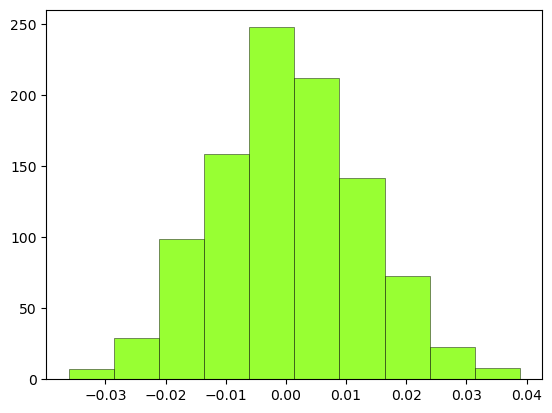

In [47]:
plt.hist(s_s_rsa, alpha = 0.8, color='chartreuse', edgecolor = 'black', linewidth=0.4 )
plt.show()

### Significance Results

In [48]:
count = 0
for i in s_s_rsa:
    if i > s_symptom_rsa:
        count = count + 1

In [49]:
print(count)

557


In [50]:
count/1000

0.557

In [89]:
count2 = 0
for i in z_s_rsa:
    if i > z_symptom_rsa:
        count2 = count2 + 1
        


In [90]:
print(count2)

374


In [53]:
count2/1000

0.374

In [54]:
print(s_symptom_rsa)
print(z_symptom_rsa)

-0.0011405929839614355
0.004216312103280057


In [55]:
count3 = 0
for i in s_z_rsa:
    if i > s_background_rsa:
        count3 = count3 + 1

In [56]:
print(count3)

131


In [57]:
count3/1000

0.131

In [58]:
count4 = 0
for i in z_z_rsa:
    if i > z_background_rsa:
        count4 = count4 + 1

In [59]:
print(count4)

875


In [60]:
count4/1000

0.875

In [61]:
print(s_background_rsa)
print(z_background_rsa)

0.012791397760823987
-0.015043097128777765


In [62]:
# clean this up and share on github
# add comments
#remove unnecessary code brain plots etc

## PCA

In [63]:
data1 = data_arr['data']
data1.shape

(1000, 64, 64, 64)

In [64]:
controls1 = data1[control,:,:,:]
controls1.shape

(500, 64, 64, 64)

In [65]:
td_datapca = controls1.reshape(500, -1)
td_datapca.shape

(500, 262144)

In [66]:
patients1 = data1[patients,:,:,:]
patients1.shape

(500, 64, 64, 64)

In [67]:
adhd_datapca = patients1.reshape(500, -1)
adhd_datapca.shape
#####

(500, 262144)

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
PCA_patients = pca.fit_transform(adhd_datapca)

In [69]:
print(pca.components_)

[[ 1.6720290e-10  8.2527165e-14 -7.5581902e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.7989242e-07 -4.5748832e-14  1.9905426e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.9934003e-07 -1.1292985e-09  9.4927533e-09 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 ...
 [ 7.1309529e-07 -3.1483776e-07  2.3714514e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-3.9885924e-07 -4.2895002e-07 -2.8993283e-10 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]
 [ 3.0076340e-08  1.2675242e-06  2.9598544e-07 ... -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00]]


In [70]:
print(sum(pca.explained_variance_ratio_))

0.9621355249546468


In [71]:
lst = np.arange(14)
var_ratio = []
for i in lst:
    pca = PCA(n_components=i)
    pca.fit(adhd_datapca)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

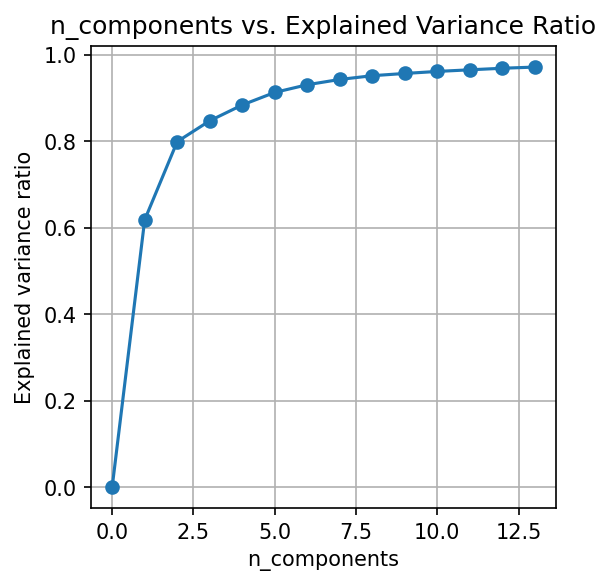

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4),dpi=150)
plt.grid()
plt.plot(lst,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.show()

### PCA RSA

In [73]:
PCA_patients
symptom = np.array(symptom_vector)
background = np.array(background_vector)

In [74]:
pca_patients_rdm = make_RDM(PCA_patients)
symptom_rdm = make_RDM(symptom)
background_rdm = make_RDM(background)

In [75]:
symptom_rdm.shape

(500, 500)

In [76]:
pca_patients_rdm.shape

(500, 500)

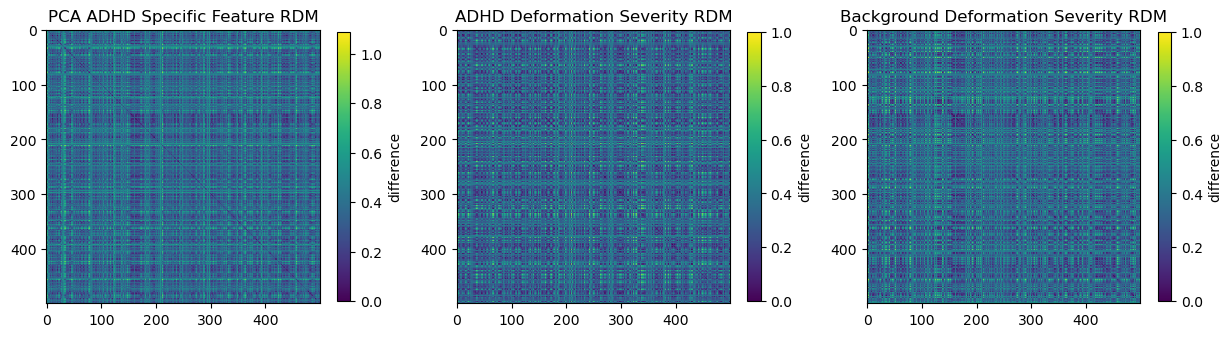

In [77]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(pca_patients_rdm)
plt.title('PCA ADHD Specific Feature RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,2)
plt.imshow(symptom_rdm)
plt.title('ADHD Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.subplot(1,3,3)
plt.imshow(background_rdm)
plt.title('Background Deformation Severity RDM')
plt.colorbar(shrink=0.7, label='difference')
plt.show()

## RSA: S Deformation

In [78]:
pca_symptom_rsa = fit_rsa(pca_patients_rdm, symptom_rdm)
pca_symptom_rsa

0.018027265468227784

## RSA: Z Deformation

In [79]:
pca_background_rsa = fit_rsa(pca_patients_rdm, background_rdm)
pca_background_rsa

0.6803262952867309

## Randomized RSA loop: PCA

In [80]:
pca_s_rsa_lst = []
pca_z_rsa_lst = []

symptom_vector = ADHDdf['S Deformation'].values
symptom = np.array(symptom_vector)

background_vector = ADHDdf['Z Deformation'].values
background = np.array(background_vector)

pca_patients_rdm = make_RDM(PCA_patients)


from sklearn.utils import shuffle

for s in range(0,1000):
    print(s)

    symptom_random = shuffle(symptom)

    rand_symptom_rdm = make_RDM(symptom_random)
    
    background_random = shuffle(background)

    rand_background_rdm = make_RDM(background_random)
    
    pca_symptom_rsa_rand = fit_rsa(pca_patients_rdm, rand_symptom_rdm)
    pca_background_rsa_rand = fit_rsa(pca_patients_rdm, rand_background_rdm)
    pca_s_rsa_lst.append(pca_symptom_rsa_rand)
    pca_z_rsa_lst.append(pca_background_rsa_rand)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Significance Results: PCA

In [81]:
pcacount = 0
for i in pca_s_rsa_lst:
    if i > pca_symptom_rsa:
        pcacount = pcacount + 1

In [82]:
print(pcacount)

130


In [83]:
pcacount/1000

0.13

In [84]:
pcacount2 = 0
for i in pca_z_rsa_lst:
    if i > pca_background_rsa:
        pcacount2 = pcacount2 + 1
        


In [85]:
print(pcacount2)

0


In [86]:
pcacount2/1000

0.0